In [13]:
from datasets import load_dataset

# Load the 'google/fleurs' dataset for 'hi_in' (Hindi - India)
dset = load_dataset("SEACrowd/indo_general_mt_en_id", trust_remote_code=True)


In [14]:
# Split the dataset into training, validation, and test sets
train_data = dset['train']
val_data = dset['validation']
test_data = dset['test']

In [15]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Embedding, Dense, Attention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

# Extract source (Indonesian) and target (English) texts from each split
train_source_texts = [example['src'] for example in train_data][:10000]
train_target_texts = [example['tgt'] for example in train_data][:10000]

val_source_texts = [example['src'] for example in val_data]
val_target_texts = [example['tgt'] for example in val_data]

test_source_texts = [example['src'] for example in test_data]
test_target_texts = [example['tgt'] for example in test_data]

In [16]:
# Add special tokens to your training data
train_target_texts = ["<SOS> " + text + " <EOS>" for text in train_target_texts]
val_target_texts = ["<SOS> " + text + " <EOS>" for text in val_target_texts]
test_target_texts = ["<SOS> " + text + " <EOS>" for text in test_target_texts]


In [17]:
train_target_texts

['<SOS> Pak Tanaka bukan murid. <EOS>',
 '<SOS> Ayah saya guru. <EOS>',
 '<SOS> Sekolah sedang libur. <EOS>',
 '<SOS> Tokyo cerah. <EOS>',
 '<SOS> Di taman ada pohon. <EOS>',
 '<SOS> Pak Tanaka ada di mana? <EOS>',
 '<SOS> Saya tidak ada uang. <EOS>',
 '<SOS> Di atas meja ada buku. <EOS>',
 '<SOS> Di bawah meja ada tas. <EOS>',
 '<SOS> Di dalam tas ada buku tulis. <EOS>',
 '<SOS> Di sebelah kanan Pak Tanaka ada Pak Yamada. <EOS>',
 '<SOS> Di sebelah kiri Pak Tanaka ada Mbak Kimura. <EOS>',
 '<SOS> Di depan rumah ada kucing. <EOS>',
 '<SOS> Di belakang rumah ada mobil. <EOS>',
 '<SOS> Pos surat ada di seberang rumah. <EOS>',
 '<SOS> Pak Yamada ada di luar kelas. <EOS>',
 '<SOS> Di depan rumah ada taman. <EOS>',
 '<SOS> Sekolah ada di dekat rumah. <EOS>',
 '<SOS> Buku di dalam tas. <EOS>',
 '<SOS> Inilah pen saya. <EOS>',
 '<SOS> Kelas bahasa Jepang di mana? <EOS>',
 '<SOS> Itu koran kapan? <EOS>',
 '<SOS> Di kelas ada komputer baru. <EOS>',
 '<SOS> Di dalam kotak ada anjing kecil. <EOS>

In [18]:
# Tokenization (Source and Target)
source_tokenizer = Tokenizer()
target_tokenizer = Tokenizer()

source_tokenizer.fit_on_texts(train_source_texts)
target_tokenizer.fit_on_texts(train_target_texts)

source_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

# Convert texts to sequences
train_source_sequences = source_tokenizer.texts_to_sequences(train_source_texts)
train_target_sequences = target_tokenizer.texts_to_sequences(train_target_texts)

val_source_sequences = source_tokenizer.texts_to_sequences(val_source_texts)
val_target_sequences = target_tokenizer.texts_to_sequences(val_target_texts)

test_source_sequences = source_tokenizer.texts_to_sequences(test_source_texts)
test_target_sequences = target_tokenizer.texts_to_sequences(test_target_texts)

In [19]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

# Define maximum sequence lengths (modify as needed)
max_source_length = max(len(seq) for seq in train_source_sequences)
max_target_length = max(len(seq) for seq in train_target_sequences)

# Pad sequences to ensure uniform length
train_source_sequences = pad_sequences(train_source_sequences, maxlen=max_source_length, padding='post')
train_target_sequences = pad_sequences(train_target_sequences, maxlen=max_target_length, padding='post')

val_source_sequences = pad_sequences(val_source_sequences, maxlen=max_source_length, padding='post')
val_target_sequences = pad_sequences(val_target_sequences, maxlen=max_target_length, padding='post')

test_source_sequences = pad_sequences(test_source_sequences, maxlen=max_source_length, padding='post')
test_target_sequences = pad_sequences(test_target_sequences, maxlen=max_target_length, padding='post')

# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_source_sequences, train_target_sequences))
val_dataset = tf.data.Dataset.from_tensor_slices((val_source_sequences, val_target_sequences))
test_dataset = tf.data.Dataset.from_tensor_slices((test_source_sequences, test_target_sequences))

# Batch and shuffle the training dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size, drop_remainder=True)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

# Print dataset samples to verify
for source, target in train_dataset.take(1):
    print('Source batch shape:', source.shape)
    print('Target batch shape:', target.shape)


Source batch shape: (32, 72)
Target batch shape: (32, 68)


In [20]:
#
# Encoder
#
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn = tf.keras.layers.SimpleRNN(
            self.enc_units,
            return_sequences=False,  # Set to True if you need the full sequence
            return_state=True,       # Set to True if you want the last state
            recurrent_initializer="glorot_uniform",
        )

    def call(self, x):
        x = self.embedding(x)
        output, state = self.rnn(x)  # Get both output and last state
        return state  # Return the last hidden state


In [21]:
#
# Decoder
#
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn = tf.keras.layers.SimpleRNN(
            self.dec_units,
            return_sequences=True,  # Set to True to return the full sequence
            return_state=True,      # Set to True to return the last state
            recurrent_initializer="glorot_uniform",
        )
        self.softmax = tf.keras.layers.Dense(vocab_size, activation="softmax")

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.rnn(inputs=x, initial_state=hidden)  # Use SimpleRNN here
        output = self.softmax(output)
        return output, state

In [22]:
# ========================================
# Create model
# ========================================

embedding_dim = 256
units = 1024  # LSTM/GRU dimensionality of the output space.

encoder = Encoder(source_vocab_size, embedding_dim, units, batch_size)
decoder = Decoder(target_vocab_size, embedding_dim, units, batch_size)

optimizer = tf.compat.v1.train.AdamOptimizer()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="val_accuracy")

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # this masks '<pad>'
    """
    Example:

    real= tf.Tensor(
    [[21  1 44 0  0]   (jump !    <eos> <pad> <pad>)
    [ 17  9 24 2 44]   (i    go   there .     <eos>)
    [ 27  1 44 0  0]   (no   !    <eos> <pad> <pad>)
    [ 21 22 32 2 44]], (i    know you   .     <eos>)
    , shape=(4, 5), dtype=int64)

    where <pad> = 0.

    mask= tf.Tensor(
    [[True  True  True False False]
    [ True  True  True True  True ]
    [[True  True  True False False]
    [ True  True  True True  True ],
    shape=(4, 5), dtype=bool)
    """

    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [23]:
CHECKPOINT = True

In [24]:
# ========================================
# Training
# ========================================

checkpoint_path = (
    "./checkpointsRNNnew/seq2seq-sample-"
    + str(500)
    + "-embedding-"
    + str(embedding_dim)
    + "-hidden-"
    + str(units)
)

if CHECKPOINT == True:
    ckpt = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print("Latest checkpoint restored!!")


@tf.function
def train(encoder, decoder, source_sentences, target_sentences, target_lang_tokenizer):
    with tf.GradientTape() as tape:
        context_vector = encoder(source_sentences)

        dec_input = target_sentences[:, :-1]  # Decoder input
        expected_dec_output = target_sentences[:, 1:]  # Expected output

        predictions, _ = decoder(dec_input, context_vector)
        loss = loss_function(expected_dec_output, predictions)
        train_accuracy(expected_dec_output, predictions)

    batch_loss = loss / int(target_sentences.shape[1])
    variables = encoder.variables + decoder.variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


@tf.function
def validate(encoder, decoder, source_sentences, target_sentences, target_lang_tokenizer):
    context_vector = encoder(source_sentences)
    dec_input = target_sentences[:, :-1]  # Decoder input
    expected_dec_output = target_sentences[:, 1:]  # Expected output

    predictions, _ = decoder(dec_input, context_vector)
    loss = loss_function(expected_dec_output, predictions)
    val_accuracy(expected_dec_output, predictions)  # Assuming you have val_accuracy defined

    return loss


# Set n_epochs at least 20 when you do training.
n_epochs = 40

# Prepare to store loss and accuracy
loss_history = []
accuracy_history = []
val_loss_history = []
val_accuracy_history = []

import time
for epoch in range(1, n_epochs + 1):
    start = time.time()

    total_loss = 0
    total_val_loss = 0
    train_accuracy.reset_states()
    val_accuracy.reset_states()  # Reset validation accuracy

    # Training loop
    for (batch, (source_sentences, target_sentences)) in enumerate(train_dataset):
        batch_loss = train(encoder, decoder, source_sentences, target_sentences, target_tokenizer)
        total_loss += batch_loss

        if batch % 100 == 0:
            print("Epoch {} Batch {} Loss {:.4f} Accuracy: {:.4f}".format(epoch, batch, batch_loss.numpy(), train_accuracy.result()))

    # Store the average loss and accuracy for this epoch
    avg_loss = total_loss / (batch + 1)
    loss_history.append(avg_loss)
    accuracy_history.append(train_accuracy.result().numpy())

    # Validation loop
    for (val_source_sentences, val_target_sentences) in val_dataset:
        val_loss = validate(encoder, decoder, val_source_sentences, val_target_sentences, target_tokenizer)
        total_val_loss += val_loss

    # Store the average validation loss and accuracy for this epoch
    avg_val_loss = total_val_loss / len(val_dataset)
    val_loss_history.append(avg_val_loss)
    val_accuracy_history.append(val_accuracy.result().numpy())

    if CHECKPOINT == True:
        ckpt_save_path = ckpt_manager.save()
        print("Saving checkpoint for epoch {} at {}".format(epoch, ckpt_save_path))

    print("Epoch {}/{} Loss {:.4f} Val Loss {:.4f}".format(epoch, n_epochs, avg_loss, avg_val_loss))
    print("Time taken for 1 epoch {:.4f} sec\n".format(time.time() - start))


2024-11-03 16:38:27.360198: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1 Batch 0 Loss 0.0152 Accuracy: 0.0000
Epoch 1 Batch 100 Loss 0.0117 Accuracy: 0.0146
Epoch 1 Batch 200 Loss 0.0091 Accuracy: 0.0162
Epoch 1 Batch 300 Loss 0.0074 Accuracy: 0.0169
Saving checkpoint for epoch 1 at ./checkpointsRNNnew/seq2seq-sample-500-embedding-256-hidden-1024/ckpt-1
Epoch 1/40 Loss 0.0096 Val Loss 1.4224
Time taken for 1 epoch 14.7390 sec

Epoch 2 Batch 0 Loss 0.0083 Accuracy: 0.0215
Epoch 2 Batch 100 Loss 0.0077 Accuracy: 0.0203
Epoch 2 Batch 200 Loss 0.0090 Accuracy: 0.0203
Epoch 2 Batch 300 Loss 0.0075 Accuracy: 0.0206
Saving checkpoint for epoch 2 at ./checkpointsRNNnew/seq2seq-sample-500-embedding-256-hidden-1024/ckpt-2
Epoch 2/40 Loss 0.0082 Val Loss 1.4478
Time taken for 1 epoch 13.9401 sec

Epoch 3 Batch 0 Loss 0.0071 Accuracy: 0.0224
Epoch 3 Batch 100 Loss 0.0074 Accuracy: 0.0218
Epoch 3 Batch 200 Loss 0.0074 Accuracy: 0.0221
Epoch 3 Batch 300 Loss 0.0065 Accuracy: 0.0223
Saving checkpoint for epoch 3 at ./checkpointsRNNnew/seq2seq-sample-500-embedding-

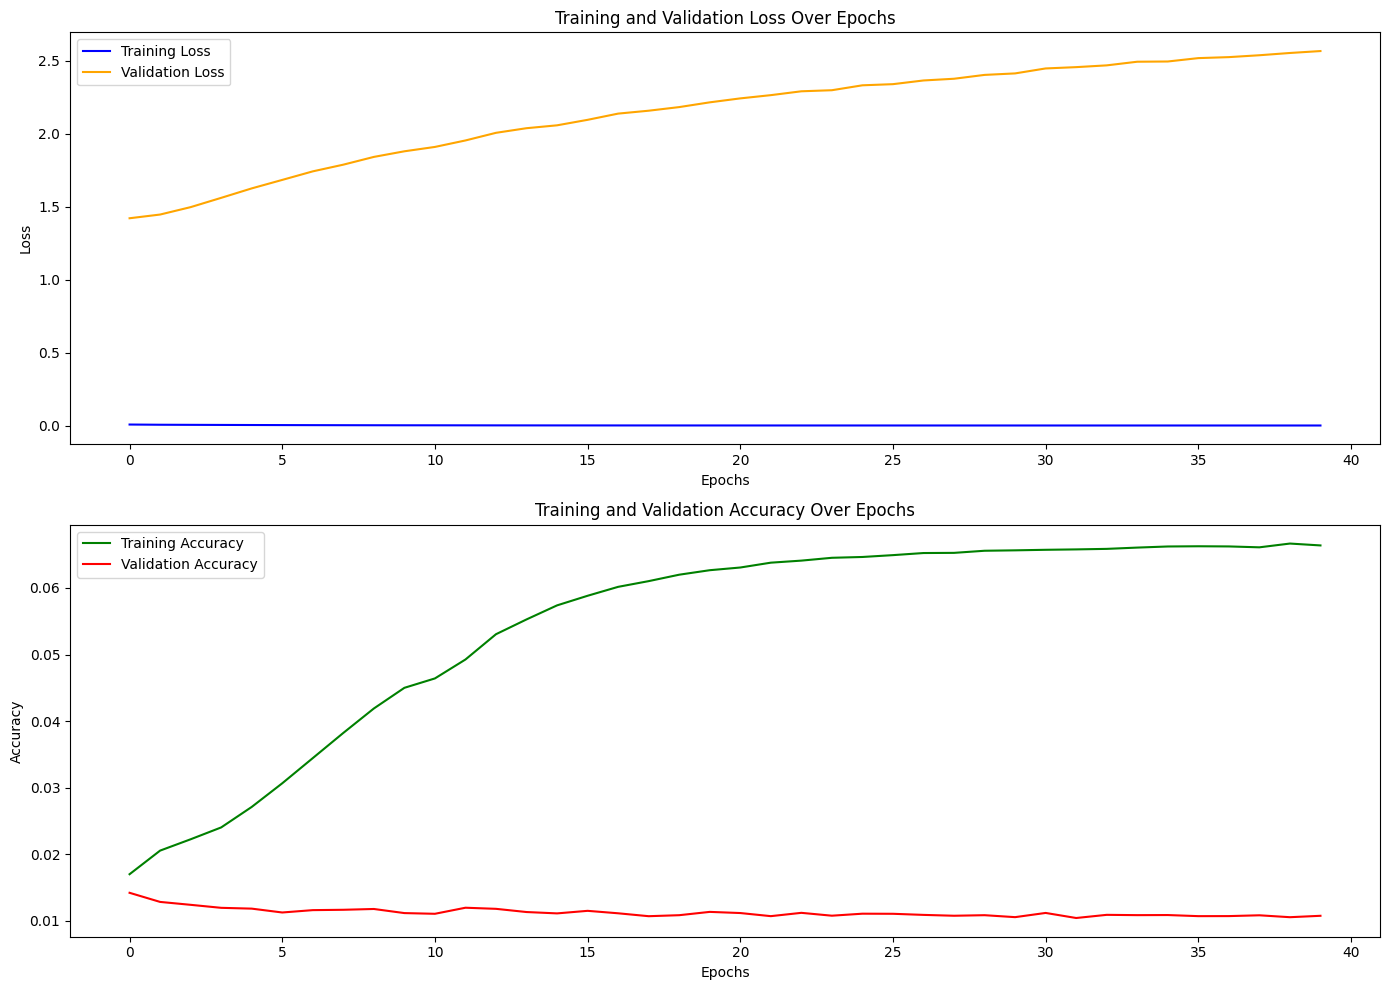

In [25]:
import matplotlib.pyplot as plt
# Plotting Loss and Accuracy
plt.figure(figsize=(14, 10))

# Loss plot
plt.subplot(2, 1, 1)
plt.plot(loss_history, label='Training Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(2, 1, 2)
plt.plot(accuracy_history, label='Training Accuracy', color='green')
plt.plot(val_accuracy_history, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [26]:
target_tokenizer.word_index

{'sos': 1,
 'eos': 2,
 'saya': 3,
 'aku': 4,
 'tidak': 5,
 'tom': 6,
 'yang': 7,
 'di': 8,
 'ini': 9,
 'itu': 10,
 'dia': 11,
 'kamu': 12,
 'apa': 13,
 'akan': 14,
 'dengan': 15,
 'ke': 16,
 'ada': 17,
 'kau': 18,
 'untuk': 19,
 'bisa': 20,
 'dan': 21,
 'pergi': 22,
 'adalah': 23,
 'dari': 24,
 'kita': 25,
 'kami': 26,
 'ingin': 27,
 'anda': 28,
 'hari': 29,
 'orang': 30,
 'sudah': 31,
 'lebih': 32,
 'sangat': 33,
 'tahu': 34,
 'pada': 35,
 'mary': 36,
 'apakah': 37,
 'harus': 38,
 'dalam': 39,
 'rumah': 40,
 'makan': 41,
 'sedang': 42,
 'karena': 43,
 'mereka': 44,
 'banyak': 45,
 'bahasa': 46,
 'kalau': 47,
 'tahun': 48,
 'pak': 49,
 'suka': 50,
 'mana': 51,
 'baik': 52,
 'telah': 53,
 'lagi': 54,
 'pernah': 55,
 'punya': 56,
 'buku': 57,
 'sini': 58,
 'anak': 59,
 'seorang': 60,
 'benar': 61,
 'datang': 62,
 'melihat': 63,
 'hal': 64,
 'sebuah': 65,
 'jalan': 66,
 'jangan': 67,
 'menjadi': 68,
 'berapa': 69,
 'mau': 70,
 'kemarin': 71,
 'laki': 72,
 'malam': 73,
 'belajar': 74,
 'la

In [27]:
# ========================================
# Translation
# ========================================

def evaluate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer):

    inputs = source_lang_tokenizer.texts_to_sequences([sentence])[0]

    inputs = tf.compat.v1.keras.preprocessing.sequence.pad_sequences(
        [inputs], maxlen=max_source_length, padding="post"
    )
    inputs = tf.convert_to_tensor(inputs)

    result = ""

    context_vector = encoder(inputs)
    dec_hidden = context_vector
    dec_input = tf.expand_dims([target_lang_tokenizer.word_index["sos"]], 0)

    for t in range(max_target_length):
        #
        # Greedy Search
        #
        predictions, dec_hidden = decoder(dec_input, dec_hidden)
        predicted_id = tf.argmax(predictions[0][0]).numpy()
        result += target_lang_tokenizer.index_word[predicted_id] + " "
        if target_lang_tokenizer.index_word[predicted_id] == "eos":
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result


def translate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer):
    result = evaluate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer)
    return result.capitalize()

"""
# for debug:
#sentence = "Su voz suena muy bello."
#sentence = "No nos gusta la lluvia."
sentence = "Nos gusta la lluvia."
result = translate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer)
print("Input    : {}".format(sentence))
print("Predicted: {}".format(result))

sys.exit()
"""
#
#
# Helper function to detokenize a sequence to text
def detokenize(sequence, tokenizer):
    return ' '.join([tokenizer.index_word.get(idx, '') for idx in sequence if idx != 0])

keys = np.arange(len(val_source_sequences))
keys = np.random.permutation(keys)[:10]

for i in range(len(keys)):
    print("===== [{}] ======".format(i + 1))
    sentence = detokenize(val_source_sequences[i], source_tokenizer)
    result = translate(sentence, encoder, decoder, source_tokenizer, target_tokenizer)
    print("Input    : {}".format(sentence))
    print("Predicted: {}".format(result))
    print("Correct  : {}".format(detokenize(val_target_sequences[i],target_tokenizer)))

encoder.summary()
decoder.summary()
decoder.get_config()

===== [1] ======
Input    : in the western half the volume increased from million per year in 1998 to in and in 2011
Predicted: Kita harus membiarkan tom pergi eos 
Correct  : sos di bagian barat volume naik dari juta per tahun pada 1998 menjadi pada dan pada 2011 eos
===== [2] ======
Input    : she obtained a scholarship from the department to study politics in the us
Predicted: Kita harus membiarkan tom pergi eos 
Correct  : sos kemudian ia mendapat beasiswa dari gereja untuk belajar di amerika serikat eos
===== [3] ======
Input    : the bridge is the main connection between downtown and new and also carries the traffic on and through
Predicted: Kita harus membiarkan tom pergi eos 
Correct  : sos jembatan ini merupakan bagian dari jalan bebas hambatan di kota dan terletak di rute eropa eos
===== [4] ======
Input    : in systems the used as for a hard are usually the received signal power and the received signal to noise the may be in an system by additional with just outside the capt

{'vocab_size': 6024, 'embedding_dim': 256, 'dec_units': 1024, 'batch_sz': 32}

In [28]:
# ========================================
# Translation
# ========================================
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction, sentence_bleu
import nltk
def evaluate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer):

    inputs = source_lang_tokenizer.texts_to_sequences([sentence])[0]

    inputs = tf.compat.v1.keras.preprocessing.sequence.pad_sequences(
        [inputs], maxlen=max_source_length, padding="post"
    )
    inputs = tf.convert_to_tensor(inputs)

    result = ""

    context_vector = encoder(inputs)
    dec_hidden = context_vector
    dec_input = tf.expand_dims([target_lang_tokenizer.word_index["sos"]], 0)

    for t in range(max_target_length):
        #
        # Greedy Search
        #
        predictions, dec_hidden = decoder(dec_input, dec_hidden)
        predicted_id = tf.argmax(predictions[0][0]).numpy()
        result += target_lang_tokenizer.index_word[predicted_id] + " "
        if target_lang_tokenizer.index_word[predicted_id] == "eos":
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result


def translate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer):
    result = evaluate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer)
    return result.capitalize()

"""
# for debug:
#sentence = "Su voz suena muy bello."
#sentence = "No nos gusta la lluvia."
sentence = "Nos gusta la lluvia."
result = translate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer)
print("Input    : {}".format(sentence))
print("Predicted: {}".format(result))

sys.exit()
"""
#
#
# Helper function to detokenize a sequence to text
def detokenize(sequence, tokenizer):
    return ' '.join([tokenizer.index_word.get(idx, '') for idx in sequence if idx != 0])


# Set the NLTK data path


def calculate_bleu(reference, hypothesis):
    # Tokenize the sentences for BLEU score calculation

    # Use the sentence_bleu function to calculate the score
    bleu_score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method1)
    return bleu_score

# ... (rest of your existing code)

keys = np.arange(len(val_source_sequences))
keys = np.random.permutation(keys)[:10]

bleu_scores = []

for i in range(len(keys)):
    print("===== [{}] ======".format(i + 1))
    sentence = detokenize(val_source_sequences[keys[i]], source_tokenizer)
    result = translate(sentence, encoder, decoder, source_tokenizer, target_tokenizer)
    print("Input    : {}".format(sentence))
    print("Predicted: {}".format(result))
    correct_sentence = detokenize(val_target_sequences[keys[i]], target_tokenizer)
    print("Correct  : {}".format(correct_sentence))
    
    # Calculate and store the BLEU score
    bleu_score = calculate_bleu(correct_sentence, result)
    bleu_scores.append(bleu_score)
    print("BLEU Score: {:.4f}".format(bleu_score))

# Calculate the average BLEU score for the sample
average_bleu_score = np.mean(bleu_scores)
print("Average BLEU Score for the sample: {:.4f}".format(average_bleu_score))

# Optionally, summarize encoder and decoder
# encoder.summary()
# decoder.summary()
# decoder.get_config()

===== [1] ======
Input    : while believes that the two were great friends only remembers her and refers to as a
Predicted: Aku tidak bisa pergi sebelum dia datang eos 
Correct  : sos begitu memintanya untuk melupakan semua karena keduanya adalah kakak adik dengan sedikit berteriak menyebut kalau dirinya sangat mencintai dan ingin supaya pria itu menjadi suaminya eos
BLEU Score: 0.0085
===== [2] ======
Input    : for this one team member had to in yet another wedding tradition
Predicted: Kita harus membiarkan tom pergi eos 
Correct  : sos pada ini salah satu anggota tim ikut serta dalam kekuatan eos
BLEU Score: 0.0101
===== [3] ======
Input    : just listen is the second play by south korean singer
Predicted: Aku tidak bisa pergi sebelum dia datang eos 
Correct  : sos adalah album kedua dari penyanyi asal korea selatan eos
BLEU Score: 0.0084
===== [4] ======
Input    : this model is specifically designed for heavy and dangerous game hunting
Predicted: Kita harus membiarkan tom pergi eo